## 0) Plot W_Ekman

- Consider an inflow angle? (either constant or Zhang and Ulhorn? Constant will be enough if I apply it to large number of data)

- Consider a smooth variation of Cd?

In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
import pandas as pd 
from tqdm.notebook import tqdm
import ephem

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Paths & Params
PTHS = {
    'sar_pth': '/home/arthur/results/sar_extended/05_addPRIMED/dsg.nc',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_VERTICAL_WIND/00_PLOT_W/',
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

In [3]:
### FUNCTIONS
def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

rs = np.linspace(10, 500000, 50000) # define dr accordingly
dr = 10 # meters
def vorticity(r, v):
    '''Relative vorticity'''
    return (1 / (r + 0.000001)) * np.gradient(r * v, dr)

def w_ekman(r, v, fcr, Cd=2.5e-3):
    '''Ekman vertical velocity'''
    rvor = vorticity(r, v)
    num  = Cd * r * (v ** 2)
    den  = rvor + fcr
    return (1 / (r + 0.000001)) * np.gradient(num / den, dr)

def w_ekman_varying_Cd(r, v, fcr):
    '''Ekman vertical velocity'''
    # Parametrize Cd
    Cd = 0.49 + 0.065 * v # cf Foster 2009
    Cd[v < 10.92]  = 1.2  # cf Foster 2009
    Cd[v >= 38.62] = 3    # cf Foster 2009
    Cd = Cd * 1e-3
    # Compute w_Ekman
    rvor = vorticity(r, v)
    num  = Cd * r * (v ** 2)
    den  = rvor + fcr
    return (1 / (r + 0.000001)) * np.gradient(num / den, dr)

In [4]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
df   = dsg.where(cond, drop=True)
print(len(df.time))

529


In [5]:
for t in tqdm(range(len(df.time))):
    d = df.isel(time=t)

    ### FIGURE
    fig = plt.figure(figsize = (18, 10))
    gs  = GridSpec(100, 100)
    
    ### Holland profile
    ax  = fig.add_subplot(gs[:, :])
    V   = holland_profile(rs, float(d.lat), float(d.B_hol), float(d.vmn_hol), float(d.rmx_hol), float(d.vmx_hol))
    ax.plot(rs / 1000, V, label='Holland fitted profile', linewidth=3, c='tab:blue')
    # ax.axvline(float(d.rmx_hol) / 2000, label='Rmax_hol / 2', c='tab:red')
    # Remove every ticks and make a bold frame
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
    ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
    ax.grid(ls=':')
    # Labels
    ax.set_ylabel(r'Total wind speed (m/s)', color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xlabel(r'Distance from center (km)')
    ax.legend(frameon=False, loc='upper center')
    ax.set_xlim(0, 500)
    
    ### w_Ekman
    ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
    w   = w_ekman(rs, V, abs(float(d.fcor)))
    w2  = w_ekman_varying_Cd(rs, V, abs(float(d.fcor)))
    ax2.plot(rs / 1000, w,  label='Estimated vertical velocity', c='tab:green')
    # ax2.plot(rs / 1000, w2, label='w_Ekman with varying Cd', c='tab:green', linestyle='dashed')
    ax2.set_ylabel('Vertical wind speed (m/s)', color='tab:green')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.legend(frameon=False, loc='upper right')

    ### Save
    plt.savefig(PTHS['sav_dir'] + os.path.splitext(d.file.item())[0], bbox_inches='tight', format='png');plt.clf()

  0%|          | 0/529 [00:00<?, ?it/s]

/tmp/ipykernel_33252/2509098393.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (18, 10))


<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

<Figure size 1800x1000 with 0 Axes>

In [19]:
tcva_dir = '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/'

In [28]:
dss = xr.open_dataset((tcva_dir + d.file_tcva).item()).isel(time=0)

<xarray.DataArray 'wind_speed' (rad: 500)> Size: 4kB
array([22.2375    , 21.78774074, 21.8940463 , 22.43334259, 23.30739815,
       24.15325926, 24.55912037, 25.01448148, 25.62842593, 26.11351852,
       26.31557407, 26.28119444, 26.45783333, 26.66883333, 26.94743519,
       27.25937963, 27.60642593, 27.83507407, 28.09782407, 28.21268519,
       28.28543519, 27.96773324, 27.3299401 , 26.87519063, 26.40812782,
       26.11340728, 25.58512073, 25.28498195, 25.15451087, 24.95122243,
       24.63282268, 24.32936387, 24.23841954, 24.01195313, 23.93622047,
       23.797334  , 23.79255667, 23.63280242, 23.33613144, 23.02724623,
       22.88947787, 22.80709722, 22.59400347, 22.3542472 , 22.05325177,
       21.76758547, 21.57585826, 21.32023348, 21.03819203, 20.9469869 ,
       20.92063962, 20.73111233, 20.68721491, 20.55150074, 20.28209077,
       20.09424479, 19.8384006 , 19.86699925, 19.83631006, 19.71801515,
       19.64562121, 19.54296591, 19.46845076, 19.33594037, 19.28572965,
       19.16691744, 19.14061828, 19.05332176, 19.05613426, 18.9603972 ,
       18.88994548, 18.78052181, 18.6561215 , 18.46433099, 18.37712657,
       18.32204009, 18.25769352, 18.16820695, 18.03218009, 17.85415079,
       17.77040476, 17.71516746, 17.66839744, 17.75437799, 17.62184295,
       17.56815705, 17.51236715, 17.50046699, 17.40845008, 17.28692834,
       17.13533981, 17.0293932 , 16.77385518, 16.53537565, 16.31468168,
       16.10191667, 15.9863015 , 15.90037791, 15.80916176, 15.80169192,
...
        8.80108527,  8.77055556,  8.75450397,  8.76616667,  8.74427083,
        8.70119658,  8.70824786,  8.71002193,  8.7490991 ,  8.70653153,
        8.65381944,  8.60662037,  8.5692619 ,  8.60568627,  8.56787879,
        8.54343434,  8.51356061,  8.47119792,  8.50666667,  8.51066667,
        8.50255556,  8.488     ,  8.46452778,  8.42640805,  8.41925287,
        8.43271605,  8.4008642 ,  8.37490741,  8.31987179,  8.27371795,
        8.25730769,  8.21442308,  8.17573333,  8.174     ,  8.15373333,
        8.08847222,  8.08736111,  8.17318841,  8.13217391,  8.12271739,
        8.10181818,  8.05439394,  8.05564394,  8.02428571,  8.15416667,
        8.14916667,  8.1025    ,  8.02591667,  8.00298246,  7.98263158,
        7.95057018,  7.98972222,  8.00117647,  8.01333333,  8.0245098 ,
        8.03764706,  7.96916667,  8.094     ,  8.07733333,  8.02488889,
        7.95916667,  7.99761905,  8.00333333,  7.98577381,  7.96339286,
        8.03128205,  8.00307692,  7.97416667,  7.97361111,  7.93305556,
        7.95944444,  7.90631944,  7.93386364,  8.02866667,  8.03566667,
        8.07833333,  8.02791667,  8.04191667,  8.04703704,  8.00259259,
        7.98555556,  8.08625   ,  7.985     ,  7.90238095,  7.87904762,
        7.81666667,  7.76428571,  7.68809524,  7.55761905,  7.53166667,
        7.818     ,  7.80666667,  7.76066667,  7.806     ,  7.79533333,
        7.65783333,  7.539     ,  7.69958333,  7.63479167,  7.87      ])
Coordinates:
    time     datetime64[ns] 8B 2024-10-10T09:07:49
  * rad      (rad) float64 4kB 0.0 1e+03 2e+03 ... 4.97e+05 4.98e+05 4.99e+05

In [12]:
# (dsg.center_quality_flag < 2) & 
# (dsg.percent_outside < 50) & 
# (dsg.percent_rmx_inside == 1) &
# (abs(dsg.lat) < 30) & 
# (dsg.rmx < 100000) & 
# (dsg.vmx > 20)

d = dsg.where(dsg.id == 'al132024', drop=True).isel(time=-1)

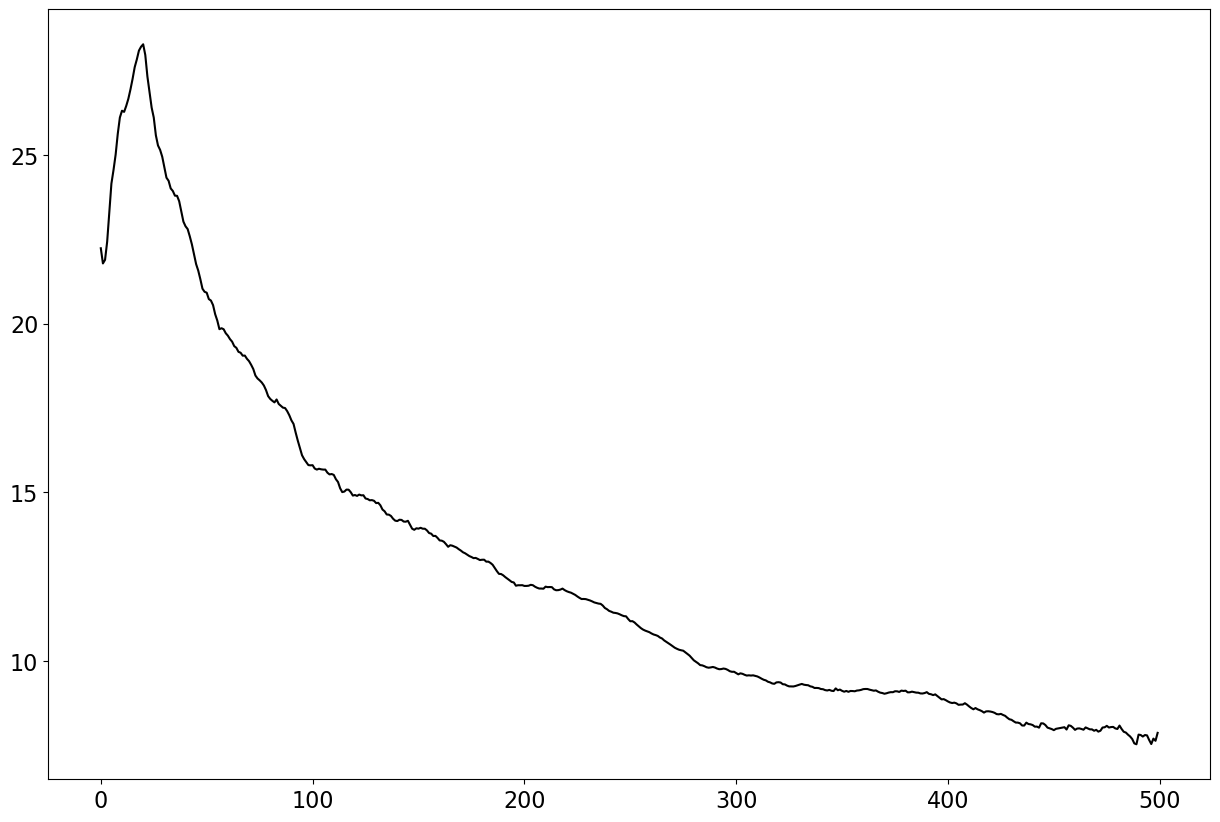

In [37]:
plt.plot(dss.rad / 1000, dss.wind_speed.mean(dim='theta'), c='k')

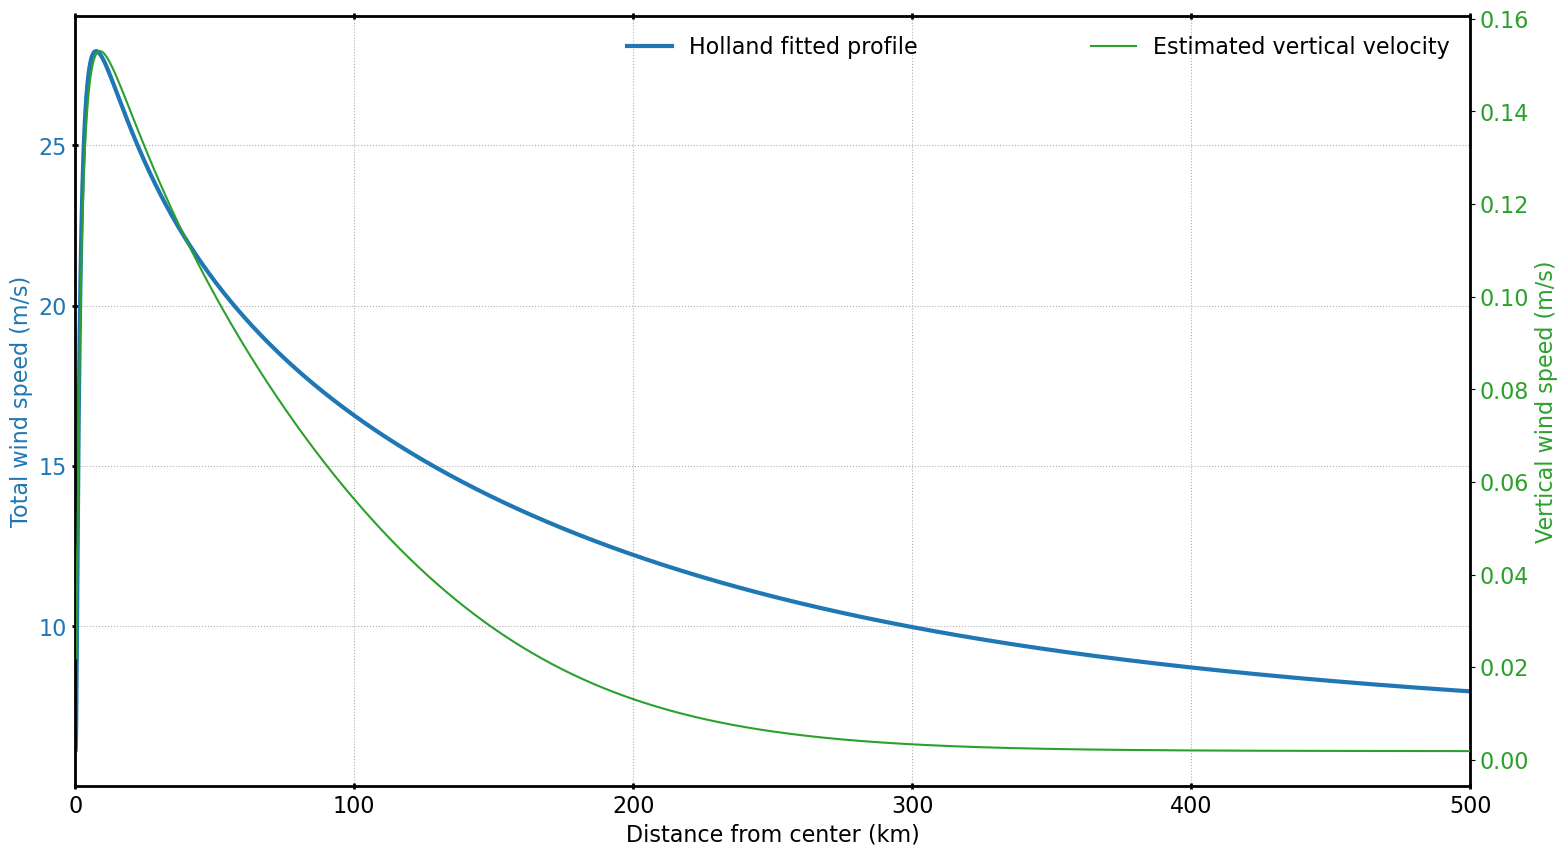

In [47]:
### FIGURE
fig = plt.figure(figsize = (18, 10))
gs  = GridSpec(100, 100)

### Holland profile
ax  = fig.add_subplot(gs[:, :])
V   = holland_profile(rs, float(d.lat), float(d.B_hol), float(d.vmn_hol), float(d.rmx_hol), float(d.vmx_hol))
ax.plot(rs / 1000, V, label='Holland fitted profile', linewidth=3, c='tab:blue')
# ax.axvline(float(d.rmx_hol) / 2000, label='Rmax_hol / 2', c='tab:red')
# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')
# Labels
ax.set_ylabel(r'Total wind speed (m/s)', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')
ax.set_xlabel(r'Distance from center (km)')
ax.set_xlim(0, 500)

### w_Ekman
ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
w   = w_ekman(rs, V, abs(float(d.fcor)))
w2  = w_ekman_varying_Cd(rs, V, abs(float(d.fcor)))
ax2.plot(rs / 1000, w,  label='Estimated vertical velocity', c='tab:green')
# ax2.plot(rs / 1000, w2, label='w_Ekman with varying Cd', c='tab:green', linestyle='dashed')
ax2.set_ylabel('Vertical wind speed (m/s)', color='tab:green')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(frameon=False, loc='upper right')

### SAR profile
# ax.plot(dss.rad / 1000, dss.wind_speed.mean(dim='theta'), c='k', linewidth=2, label='SAR wind profile')
# ax.fill_between(dss.rad / 1000, dss.wind_speed.mean(dim='theta') - dss.wind_speed.std(dim='theta'), dss.wind_speed.mean(dim='theta') + dss.wind_speed.std(dim='theta'), color='k', alpha=0.1)
ax.legend(frameon=False, loc='upper center')

## Single case

In [101]:
# ### FIGURE
# fig = plt.figure(figsize = (18, 10))
# gs  = GridSpec(100, 100)

# ### Holland profile
# ax  = fig.add_subplot(gs[:, :])
# V   = holland_profile(rs, float(d.lat), float(d.B_hol), float(d.vmn_hol), float(d.rmx_hol), float(d.vmx_hol))
# ax.plot(rs / 1000, V, label='Holland fitted profile', linewidth=3, c='tab:blue')
# ax.axvline(float(d.rmx_hol) / 2000, label='Rmax_hol / 2', c='tab:red')
# # Remove every ticks and make a bold frame
# for axis in ['top', 'bottom', 'left', 'right']:
#     ax.spines[axis].set_linewidth(2)
# ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# # Labels
# ax.set_ylabel(r'Total wind speed (m/s)', color='tab:blue')
# ax.tick_params(axis='y', labelcolor='tab:blue')
# ax.set_xlabel(r'Distance from center (km)')
# ax.legend(frameon=False, loc='upper center')
# ax.set_xlim(0, 500)

# # w_Ekman
# ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
# w   = w_ekman(rs, V, abs(float(d.fcor)))
# w2  = w_ekman_varying_Cd(rs, V, abs(float(d.fcor)))
# ax2.plot(rs / 1000, w,  label='w_Ekman', c='tab:green')
# ax2.plot(rs / 1000, w2, label='w_Ekman with varying Cd', c='tab:green', linestyle='dashed')
# ax2.set_ylabel('Vertical wind speed (m/s)', color='tab:green')  # we already handled the x-label with ax1
# ax2.tick_params(axis='y', labelcolor='tab:green')
# ax2.legend(frameon=False, loc='upper right')

In [92]:
# ### FIGURE
# fig = plt.figure(figsize = (12, 15))
# gs  = GridSpec(100, 100)

# ### Holland profile
# ax  = fig.add_subplot(gs[:46, :])
# V   = holland_profile(rs, float(d.lat), float(d.B_hol), float(d.vmn_hol), float(d.rmx_hol), float(d.vmx_hol),)
# ax.plot(rs / 1000, V, label='Holland fitted profile')
# ax.axvline(float(d.rmx_hol) / 2000, label='Rmax_hol / 2', c='tab:red')
# # Remove every ticks and make a bold frame
# for axis in ['top', 'bottom', 'left', 'right']:
#     ax.spines[axis].set_linewidth(2)
# ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# # Labels
# ax.set_ylabel(r'Total wind speed (m/s)')
# ax.set_xlabel(r'Distance from center (km)')
# ax.legend(frameon=False, loc='upper right')
# ax.set_xlim(0, 500)

# ### w_Ekman
# ax  = fig.add_subplot(gs[54:, :])
# w   = w_ekman(rs, V, abs(float(d.fcor)))
# ax.plot(rs / 1000, w, label='w_Ekman')
# ax.axvline(float(d.rmx_hol) / 2000, label='Rmax_hol / 2', c='tab:red')
# # Remove every ticks and make a bold frame
# for axis in ['top', 'bottom', 'left', 'right']:
#     ax.spines[axis].set_linewidth(2)
# ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
# ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
# ax.grid(ls=':')
# # Labels
# ax.set_ylabel(r'Total wind speed (m/s)')
# ax.set_xlabel(r'Distance from center (km)')
# ax.legend(frameon=False, loc='upper right')
# ax.set_xlim(0, 500)